In [1]:
# 시스템 명: 봉사 동아리용 데이터 처리 시스템
# 용도: 봉사동아리의 활동/부원 관리 및 분석 용
# 제작자: 아트엔테크놀로지학과 20221052 심규재
# 제출일: 2024-06-25

#############################################
# <<실행시 유의사항>>

# 1.Colab 상에서 실행하는 것을 권장합니다.
# 2.함께 첨부된 파일들을 왼쪽 '파일' 탭을 누르고 '세션 저장소에 업로드' 한후 실행해야 합니다.

#############################################
# <<데이터 셋 설명>>

# LOGIN.xlsx->(ID:INT, PW:INT)
# ex)20221052 1234
# 로그인에 사용할 학번과 비밀번호를 저장합니다.

# MEMBER.xlsx->(ID, NAME, COURSE: INT, ISOB:BOOLEAN, ISMANAGER:BOOLEAN, PHONENUM:STR
# ex) 20221052 심규재 아트엔테크놀로지학과 2022.03.01 False False 010-0000-0000
# 동아리원 50명의 정보인 학번, 이름, 학과, 동아리가입일자, 동아리 비활동 여부, 임원진 여부, 전화번호를 저장합니다.

# ACT.xlsx->(ACTNAME:VARCHAR, HOUR:INT,TYPE:VARCHAR)
# ex)멘토링 3 봉사
# 동아리의 활동 명, 활동 소요 시간, 해당 활동이 봉사인지 모임인지 저장합니다.

# PARTICIPATE2023.xlsx->(ID:INT, 3월총회:BOOLEAN 4월총회:BOOLEAN 5월총회:BOOLEAN 6월총회:BOOLEAN 9월총회:BOOLEAN 10월총회:BOOLEAN 11월총회:BOOLEAN 12월총회:BOOLEAN
# 밥집배식:INT, 멘토링:INT,유기견보호소:INT, 플로깅:INT
# ex)멘토링 3 봉사
# 2023년도에 어느 부원이 어느 모임 활동에 참여했는가(T/F)와 어느 봉사활동을 몇번이나 참여했는가(0~3회)를 저장합니다.

# PARTICIPATE2024.xlsx->(ID:INT, 3월총회:BOOLEAN 4월총회:BOOLEAN 5월총회:BOOLEAN 6월총회:BOOLEAN 9월총회:BOOLEAN 10월총회:BOOLEAN 11월총회:BOOLEAN 12월총회:BOOLEAN
# 밥집배식:INT, 멘토링:INT,유기견보호소:INT, 플로깅:INT
# 2024년도에 어느 부원이 어느 모임 활동에 참여했는가(T/F)와 어느 봉사활동을 몇번이나 참여했는가(0~3회)를 저장합니다.

#padasql
!pip install pandasql

import pandas as pd
import pandasql as ps
import time
import re
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import os
from scipy.stats import norm
from datetime import datetime

# 한글 폰트 설정
# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정


  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=8d84c413dc1206e6bcb85115661da0128435dd35fb17166abdfabc992334af83
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
#전역 변수

# 월별총회 열 이름 리스트
assembly_columns = ['3월총회', '4월총회', '5월총회', '6월총회', '9월총회', '10월총회', '11월총회', '12월총회']
volunteer_columns = ['밥집배식', '멘토링', '유기견보호소', '플로깅']

In [3]:
# 메뉴 구분 용 CUI 메소드
def printline():
    print("--------------------------------------------------------------------------------")

In [4]:
# 사용자 로그인 메소드
def authenticate_user(user_id, password):
    # 아이디 비밀번호 데이터
    df = pd.read_excel('LOGIN.xlsx', sheet_name='Sheet1')

    # 아이디와 비밀번호가 일치하는 행 찾기
    user_row = df[(df['ID'] == user_id) & (df['PW'] == password)]

    if not user_row.empty:
        return True
    else:
        return False

In [5]:
# 전화번호 유효성 검증 메소드
def is_valid_phone_number(phone_number):
    # 전화번호 정규식 패턴 정의
    pattern = re.compile(r"^010-\d{4}-\d{4}$")

    # 패턴과 입력값을 매칭
    if pattern.match(phone_number):
        return True
    else:
        return False

In [6]:
# 변동사항 기록용 로그 파일 작성 메소드
filename = 'log.txt'

def log_data(filename, data):
    with open(filename, 'a') as file:
        file.write(data + '\n')

In [7]:
#1 계정 관리 메소드
# MEMBER.xlsx의 (COURSE, PHONENUM) 수정 가능
def AccountManager(user_id):

    df = pd.read_excel("MEMBER.xlsx", sheet_name='Sheet1')
    df.set_index('ID', inplace=True)#수정 기능

    while True:
        printline()
        print(">>계정 관리 메뉴입니다")
        print("1. 내 정보 조회")
        print("2. 내 정보 수정")
        print("0. 뒤로 가기")
        printline()
        choice = input(">>서브 메뉴를 선택하세요: ")

        if choice == '1':
            print(">>내 정보를 조회 합니다\n")

            print(df.loc[user_id])
            print("\n>>5초 후 서브메뉴로 돌아갑니다")
            time.sleep(5)

        elif choice == '2':

            while True:
                print(">>수정하고 싶은 정보를 선택합니다")
                printline()
                print("1. 학과 정보 수정")
                print("2. 전화번호 정보 수정")
                print("0. 뒤로 가기")
                printline()
                choice = input(">>서브 메뉴를 선택하세요: ")

                if choice == '1':
                    #변경된 학과(COURSE) 정보 입력
                    course = input(">>변경된 학과명을 입력하세요: ")
                    df.loc[user_id, "COURSE"]= course
                    print(df.loc[user_id])
                    df.to_excel("MEMBER.xlsx", sheet_name='Sheet1')
                    print("\n>>변경된 데이터가 MEMBER.xlsx 파일에 저장되었습니다.")
                    print("\n>>5초 후 서브메뉴로 돌아갑니다")
                    time.sleep(5)

                elif choice == '2':
                    #변경된 전화번호(PHONENUM) 정보
                    phonenum = input(">>변경된 전화번호를 입력하세요(010-XXXX-XXXX): ")
                    if is_valid_phone_number(phonenum):
                        df.loc[user_id, "PHONENUM"]= phonenum
                        print(df.loc[user_id])
                        df.to_excel("MEMBER.xlsx", sheet_name='Sheet1')
                        print("\n>>변경된 데이터가 MEMBER.xlsx 파일에 저장되었습니다.")
                        print("\n>>5초 후 서브메뉴로 돌아갑니다")
                        time.sleep(5)
                    else:
                        print("---잘못된 전화번호 형식입니다---")

                elif choice == '0':
                    break
                else:
                    print("---잘못된 선택입니다 다시 시도하세요---")
        elif choice == '0':
            break
        else:
            print("---잘못된 선택입니다 다시 시도하세요---")

In [8]:
#2 활동 내역 확인 메소드
def MyActivityInfo(user_id):
    try:
        df = pd.read_excel("PARTICIPATE2023.xlsx", sheet_name='Sheet1')
        df = df.set_index('ID')
        user_data = df.loc[user_id].copy()  # .copy()를 사용하여 복사(원본 변형 에러 방지)

        # 각 총회 열을 True/False로 변환
        for col in assembly_columns:
            if user_data[col] == 1.0:
                user_data[col] = True
            elif user_data[col] == 0.0:
                user_data[col] = False

        print(">>2023년의 활동 내역을 불러옵니다:\n")
        print(user_data)
    except:
        print("---해당 ID의 2023년의 활동 내역이 없습니다---")
    try:
        df = pd.read_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')
        df = df.set_index('ID')
        user_data = df.loc[user_id].copy()  # .copy()를 사용하여 복사(원본 변형 에러 방지)

        # 각 총회 열을 True/False로 변환
        for col in assembly_columns:
            if user_data[col] == 1.0:
                user_data[col] = True
            elif user_data[col] == 0.0:
                user_data[col] = False

        print(">>2024년의 활동 내역을 불러옵니다:\n")
        print(user_data)
    except:
        print("---해당 ID의 2024년의 활동 내역이 없습니다---")

    print("\n>>5초 후 서브메뉴로 돌아갑니다")
    time.sleep(5)

In [9]:
#3 활동관리 메소드
def ActivityManager():
    while True:
        print(">>활동 관리 서브메뉴를 선택합니다")
        printline()
        print("1. 동아리 활동 목록 조회")
        print("2. 연도별 전체 활동 내역 조회")
        print("3. 부원 활동 내역 변경")
        print("0. 뒤로 가기")
        printline()
        choice = input(">>서브 메뉴를 선택하세요: ")

        if choice == '1':#동아리 활동 목록 조회
            df = pd.read_excel("ACT.xlsx", sheet_name='Sheet1')
            df.set_index('ACTNAME', inplace=True)#인덱스
            print(df)
            print("\n>>5초 후 서브메뉴로 돌아갑니다")
            time.sleep(5)

        elif choice == '2':#연도별 전체 활동 내역 조회
            printline()
            print(">>2023년 활동 기록 조회")
            try:
                df = pd.read_excel("PARTICIPATE2023.xlsx", sheet_name='Sheet1')#2023년
                df.set_index('ID', inplace=True)
                print(df)
            except:
                print("2023년도의 활동 내역이 없습니다.")
            printline()


            print(">>2024년 활동 기록 조회")
            try:
                df = pd.read_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')#2024년
                df.set_index('ID', inplace=True)
                print(df)
            except:
                print("2024년도의 활동 내역이 없습니다.")

            printline()
            print("\n>>10초 후 서브메뉴로 돌아갑니다")
            time.sleep(10)

        elif choice == '3':#부원 활동 내역 변경
            df = pd.read_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')#2024년 활동 기준
            df.set_index('ID', inplace=True)

            # ID 입력 받기
            user_id = int(input(">>변경할 부원의 학번을 입력하세요:ex)20230618"))
            try:
                user_data = df.loc[user_id]
                printline()
                print(">>변경전 데이터:")
                print(user_data)
                printline()
                # 변경할 활동명 입력 받기
                attribute = input(">>변경할 활동명을 입력하세요 (예: 3월총회,밥집배식,멘토링,유기견보호소, 플로깅 등): ")

                if attribute in assembly_columns:# 총회 열 변경
                    df.loc[user_id, attribute] = True
                    print(f">>{attribute} 참석 여부가 True(참여)로 변경되었습니다.")

                elif attribute in df.columns.difference(['ID']):
                    # 총회가 아닌 데이터 1씩 증가
                    df.loc[user_id, attribute] += 1
                    print(f"{attribute}의 값이 증가되었습니다.")
                else:
                    print(f"---{attribute}은(는) 유효한 속성명이 아닙니다---")

                # 변경된 데이터 출력
                printline()
                print(">>변경된 데이터:")
                print(df.loc[user_id])
                printline()

                # 변경된 데이터프레임을 엑셀 파일에 저장
                df.to_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')
            except:
                print(f"---ID {user_id}를 찾을 수 없습니다---")
        elif choice == '0':
            break
        else:
            print("---잘못된 선택입니다 다시 시도하세요---")

In [10]:
#4 부원관리 메소드
def MemberManager():
    while True:
        print(">>부원관리 서브메뉴를 선택합니다")
        printline()
        print("1. 활동 부원 명단 조회")
        print("2. 신입 부원 추가")
        print("3. 기존 부원 탈퇴")
        print("4. 기존 부원 OB 변경")
        print("5. OB 선배 연락처 명단 조회")
        print("0. 뒤로 가기")
        printline()
        choice = input(">>서브 메뉴를 선택하세요: ")

        if choice == '1':
            df = pd.read_excel("MEMBER.xlsx", sheet_name='Sheet1')
            df.set_index('ID', inplace=True)#수정 기능
            # SQL 쿼리 정의
            query = """
                    SELECT ID, NAME, REGISTERSEMESTER
                    FROM df
                    WHERE ISOB = 0
                    """
            result = ps.sqldf(query, locals())
            print(result)
            print("\n>>5초 후 서브메뉴로 돌아갑니다")
            time.sleep(5)

        elif choice == '2':
            #신입부원 추가
            df = pd.read_excel("MEMBER.xlsx", sheet_name='Sheet1')
            df.set_index('ID', inplace=True)#수정 기능
            newbie_id = int(input(">>신입 부원의 학번을 입력하세요(20XXXXXX): "))
            newbie_name = input(">>신입 부원의 이름을 입력하세요: ")
            newbie_course = input(">>신입 부원의 학과명을 입력하세요: ")
            newbie_semester = input(">>신입 부원의 등록 학기를 입력하세요(YYYY.MM.DD): ")
            newbie_phonenum = input(">>신입 부원의 전화번호를 입력하세요(010-XXXX-XXXX): ")
            newbie_password = int(input(">>사용할 비밀번호 네자리를 입력하세요:(0으로 시작하면 안됩니다) "))
            df.loc[newbie_id]= [newbie_name, newbie_course, newbie_semester, False, False, newbie_phonenum]
            printline()
            print(df.loc[newbie_id])
            df.to_excel("MEMBER.xlsx", sheet_name='Sheet1')
            print("\n>>수정된 데이터가 MEMBER.xlsx 파일에 저장되었습니다.")
            printline()
            time.sleep(3)

            #PARTICIPATE 추가
            df = pd.read_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')
            df.set_index('ID', inplace=True)#수정 기능
            df.loc[newbie_id]= [False,False,False,False,False,False,False,False,0,0,0,0]
            print(df.loc[newbie_id])
            df.to_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')
            print("\n>>수정된 데이터가 PARTICIPATE2024.xlsx 파일에 저장되었습니다.")
            printline()
            time.sleep(3)

            #LOGIN 추가
            df = pd.read_excel("LOGIN.xlsx", sheet_name='Sheet1')
            df.set_index('ID', inplace=True)#수정 기능
            df.loc[newbie_id]= [newbie_password]
            print(df.loc[newbie_id])
            df.to_excel("LOGIN.xlsx", sheet_name='Sheet1')
            print("\n>>수정된 데이터가 LOGIN.xlsx 파일에 저장되었습니다.")
            printline()
            print("\n>>5초 후 서브메뉴로 돌아갑니다")
            log_data(filename, f"{newbie_id}-> 등록 완료")
            time.sleep(5)

        elif choice == '3':
            #기존 부원 탈퇴
            delete_id = int(input(">>탈퇴하는 부원의 학번을 입력하세요: "))
            df = pd.read_excel("MEMBER.xlsx", sheet_name='Sheet1')
            df.set_index('ID', inplace=True)
            try:#MEMBER 삭제
                df.drop(delete_id, inplace=True)
                df.to_excel("MEMBER.xlsx", sheet_name='Sheet1')
                print("\n>>MEMBER.xlsx에서 데이터가 삭제되었습니다.")
                time.sleep(3)
                try:#LOGIN 삭제
                    df = pd.read_excel("LOGIN.xlsx", sheet_name='Sheet1')
                    df.set_index('ID', inplace=True)
                    df.drop(delete_id, inplace=True)
                    df.to_excel("LOGIN.xlsx", sheet_name='Sheet1')
                    print("\n>>LOGIN.xlsx에서 데이터가 삭제되었습니다.")
                    time.sleep(3)
                    try:#PARTICIPATE2023 삭제
                        df = pd.read_excel("PARTICIPATE2023.xlsx", sheet_name='Sheet1')
                        df.set_index('ID', inplace=True)
                        df.drop(delete_id, inplace=True)
                        df.to_excel("PARTICIPATE2023.xlsx", sheet_name='Sheet1')
                        print("\n>>PARTICIPATE2023.xlsx에서 데이터가 삭제되었습니다.")
                        log_data(filename, f"{delete_id}-> 탈퇴 완료")

                        time.sleep(3)
                    except:#예외처리
                        print("---PARTICIPATE2023.xlsx에 데이터가 없습니다.---")
                    try:#PARTICIPATE2024 삭제
                        df = pd.read_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')
                        df.set_index('ID', inplace=True)
                        df.drop(delete_id, inplace=True)
                        df.to_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')
                        print("\n>>PARTICIPATE2024.xlsx에서 데이터가 삭제되었습니다.")
                        time.sleep(3)
                    except:#예외처리
                        print("---PARTICIPATE2024.xlsx에 데이터가 없습니다---")
                except:#예외처리
                    print("---LOGIN.xlsx에서 데이터 삭제 실패, 수동으로 시도하세요---")
            except:#예외처리
                print("---MEMBER.xlsx에서 데이터 삭제 실패, 수동으로 시도하세요---")

            print("\n>>5초 후 서브메뉴로 돌아갑니다")
            time.sleep(5)

        elif choice == '4':
            #기존 부원 ob 변경
            df = pd.read_excel("MEMBER.xlsx", sheet_name='Sheet1')
            df.set_index('ID', inplace=True)#수정 기능
            oldbie_id = int(input(">>변경할 부원의 학번을 입력하세요(20XXXXXX): "))
            df.loc[oldbie_id, 'ISOB']= 1
            print(df.loc[oldbie_id])
            df.to_excel("MEMBER.xlsx", sheet_name='Sheet1')
            print("\n>>수정된 데이터가 MEMBER.xlsx 파일에 저장되었습니다.")
            print("\n>>5초 후 서브메뉴로 돌아갑니다")
            log_data(filename, f"{oldbie_id}-> OB 변경 완료")
            time.sleep(5)

        elif choice == '5':
            #OB 명단 조회
            df = pd.read_excel("MEMBER.xlsx", sheet_name='Sheet1')
            df.set_index('ID', inplace=True)
            # SQL 쿼리 정의
            query = """
                    SELECT ID, NAME, PHONENUM
                    FROM df
                    WHERE ISOB = 1
                    """
            result = ps.sqldf(query, locals())
            print(result)
            print("\n>>5초 후 서브메뉴로 돌아갑니다")
            time.sleep(5)

        elif choice == '0':
            break
        else:
            print("---잘못된 선택입니다 다시 시도하세요---")

In [11]:
#5 동아리 활동 통계 메소드
def ActivityStatistics():
    while True:
        printline()
        print("연간 통계 서브 메뉴")
        print("1. 월별 총회 참여도")
        print("2. 봉사활동별 참여도")
        print("3. 봉사 시간 히스토그램과 정규분포")
        print("0. 뒤로 가기")
        printline()
        choice = input(">>메뉴를 선택하세요: ")
        df_2023 = pd.read_excel("PARTICIPATE2023.xlsx", sheet_name='Sheet1')
        df_2023.set_index('ID', inplace=True)
        df_2024 = pd.read_excel("PARTICIPATE2024.xlsx", sheet_name='Sheet1')
        df_2024.set_index('ID', inplace=True)

        if choice == '1':
            # 각 열에서 TRUE와 FALSE의 개수 세기
            true_counts = df_2023[assembly_columns].sum()
            false_counts = (~df_2023[assembly_columns]).sum()

            # 그래프 설정
            plt.figure(figsize=(10, 6))  # 그림 크기 설정

            # 바 그래프 그리기
            bar_width = 0.4
            plt.bar(true_counts.index, true_counts, width=bar_width, label='참여', color='b', align='center')
            plt.bar(false_counts.index, false_counts, width=bar_width, label='불참', color='r', align='edge')

            # 축 레이블 및 타이틀 설정
            plt.xlabel('월별 총회')
            plt.ylabel('참여도')
            plt.title('2023년도 월별 총회 참여도')

            # 범례 표시
            plt.legend()

            # 그리드 추가
            plt.grid(True)

            # 그래프 표시
            plt.tight_layout()
            plt.show()

            # 각 열에서 TRUE와 FALSE의 개수 세기
            true_counts = df_2024[assembly_columns].sum()
            false_counts = (~df_2024[assembly_columns]).sum()

            # 그래프 설정
            plt.figure(figsize=(10, 6))  # 그림 크기 설정

            # 바 그래프 그리기
            bar_width = 0.4
            plt.bar(true_counts.index, true_counts, width=bar_width, label='참여', color='b', align='center')
            plt.bar(false_counts.index, false_counts, width=bar_width, label='불참', color='r', align='edge')

            # 축 레이블 및 타이틀 설정
            plt.xlabel('월별 총회')
            plt.ylabel('참여도')
            plt.title('2024년도 월별 총회 참여도')

            # 범례 표시
            plt.legend()

            # 그리드 추가
            plt.grid(True)

            # 그래프 표시
            plt.tight_layout()
            plt.show()

        elif choice == '2':
            # 봉사활동별 참여도 계산
            activities = ['밥집배식', '멘토링', '유기견보호소', '플로깅']

            # 각 봉사활동(밥집배식, 멘토링, 유기견보호소, 플로깅)의 값(0, 1, 2, 3)의 개수 세기
            counts = {
                '밥집배식': df_2023['밥집배식'].value_counts().reindex([0, 1, 2, 3], fill_value=0),
                '멘토링': df_2023['멘토링'].value_counts().reindex([0, 1, 2, 3], fill_value=0),
                '유기견보호소': df_2023['유기견보호소'].value_counts().reindex([0, 1, 2, 3], fill_value=0),
                '플로깅': df_2023['플로깅'].value_counts().reindex([0, 1, 2, 3], fill_value=0)
            }

            # 원형 차트 그리기
            plt.figure(figsize=(12, 8))

            labels = ['0회', '1회', '2회', '3회']
            colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

            for i, (activity, count) in enumerate(counts.items()):
                plt.subplot(2, 2, i + 1)
                plt.pie(count, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
                plt.title(f'2023년 {activity} 봉사 참여도')

            plt.tight_layout()
            plt.show()

            # 봉사활동별 참여도 계산
            activities = ['밥집배식', '멘토링', '유기견보호소', '플로깅']

            # 각 봉사활동(밥집배식, 멘토링, 유기견보호소, 플로깅)의 값(0, 1, 2, 3)의 개수 세기
            counts = {
                '밥집배식': df_2024['밥집배식'].value_counts().reindex([0, 1, 2, 3], fill_value=0),
                '멘토링': df_2024['멘토링'].value_counts().reindex([0, 1, 2, 3], fill_value=0),
                '유기견보호소': df_2024['유기견보호소'].value_counts().reindex([0, 1, 2, 3], fill_value=0),
                '플로깅': df_2024['플로깅'].value_counts().reindex([0, 1, 2, 3], fill_value=0)
            }

            # 원형 차트 그리기
            plt.figure(figsize=(12, 8))

            labels = ['0회', '1회', '2회', '3회']
            colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

            for i, (activity, count) in enumerate(counts.items()):
                plt.subplot(2, 2, i + 1)
                plt.pie(count, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
                plt.title(f'2024년 {activity} 봉사 참여도')

            plt.tight_layout()
            plt.show()

        elif choice == '3':
            # 각 봉사활동별 시간 계산
            df_2023['밥집배식_시간'] = df_2023['밥집배식'] * 2
            df_2023['멘토링_시간'] = df_2023['멘토링'] * 3
            df_2023['유기견보호소_시간'] = df_2023['유기견보호소'] * 4
            df_2023['플로깅_시간'] = df_2023['플로깅'] * 1

            # 각 ID의 총 봉사시간 계산
            df_2023['총봉사시간'] = df_2023['밥집배식_시간'] + df_2023['멘토링_시간'] + df_2023['유기견보호소_시간'] + df_2023['플로깅_시간']

            # 총 봉사시간을 정규분포와 히스토그램으로 시각화
            plt.figure(figsize=(10, 6))


            mean = df_2023['총봉사시간'].mean()
            std = df_2023['총봉사시간'].std()
            # 정규분포의 x 값 범위 설정
            xmin = df_2023['총봉사시간'].min()
            xmax = df_2023['총봉사시간'].max()
            x = np.linspace(xmin, xmax, 100)

            # 정규분포 곡선 계산
            fit = norm.pdf(x, mean, std)

            # 히스토그램과 정규분포 곡선을 동시에 그리기
            plt.figure(figsize=(10, 6))

            plt.hist(df_2023['총봉사시간'], bins=10, density=True, alpha=0.75, edgecolor='black', label='봉사시간 히스토그램')
            plt.plot(x, fit, linewidth=2, color='r', label='정규분포')
            plt.title('2023년 봉사시간의 히스토그램과 정규분포')
            plt.xlabel('봉사시간')
            plt.ylabel('확률 밀도')
            plt.legend()

            plt.show()

            # 각 봉사활동별 시간 계산
            df_2024['밥집배식_시간'] = df_2024['밥집배식'] * 2
            df_2024['멘토링_시간'] = df_2024['멘토링'] * 3
            df_2024['유기견보호소_시간'] = df_2024['유기견보호소'] * 4
            df_2024['플로깅_시간'] = df_2024['플로깅'] * 1

            # 각 ID의 총 봉사시간 계산
            df_2024['총봉사시간'] = df_2024['밥집배식_시간'] + df_2024['멘토링_시간'] + df_2024['유기견보호소_시간'] + df_2024['플로깅_시간']

            # 총 봉사시간을 정규분포와 히스토그램으로 시각화
            plt.figure(figsize=(10, 6))


            mean = df_2024['총봉사시간'].mean()
            std = df_2024['총봉사시간'].std()
            # 정규분포의 x 값 범위 설정
            xmin = df_2024['총봉사시간'].min()
            xmax = df_2024['총봉사시간'].max()
            x = np.linspace(xmin, xmax, 100)

            # 정규분포 곡선 계산
            fit = norm.pdf(x, mean, std)

            # 히스토그램과 정규분포 곡선을 동시에 그리기
            plt.figure(figsize=(10, 6))

            plt.hist(df_2024['총봉사시간'], bins=10, density=True, alpha=0.75, edgecolor='black', label='봉사시간 히스토그램')
            plt.plot(x, fit, linewidth=2, color='r', label='정규분포')
            plt.title('2024년 봉사시간의 히스토그램과 정규분포')
            plt.xlabel('봉사시간')
            plt.ylabel('확률 밀도')
            plt.legend()

            plt.show()
        elif choice == '0':
            break
        else:
            print("---잘못된 선택입니다 다시 시도하세요---")

In [12]:
#6 인수인계 메소드
def Conclave(user_id):
    df = pd.read_excel("MEMBER.xlsx", sheet_name='Sheet1')
    df.set_index('ID', inplace=True)#수정 기능
    newexec_id = int(input(">>새로운 운영진의 학번을 입력하세요: "))
    newexec_password = int(input(">>비밀번호 네자리를 입력하세요: "))
    if authenticate_user(input_id, input_password):
        print("\n---인증 성공---\n")
        df.loc[input_id, "ISMANAGER"]= False
        df.loc[newexec_id, "ISMANAGER"]= True
        print(df.loc[input_id])
        print(df.loc[newexec_id])

        df.to_excel("MEMBER.xlsx", sheet_name='Sheet1')
        print("\n>>수정된 데이터가 MEMBER.xlsx 파일에 저장되었습니다.")
        print("\n>>5초 후 서브메뉴로 돌아갑니다")
        log_data(filename, f"{input_id}->{newexec_id} 인수인계 완료")
        time.sleep(5)
    else:
        print("\n---인증 실패---\n")

In [13]:
# 일반 부원 용 메뉴(VIEW)
def handle_user_menu():
    while True:
        printline()
        print("사용자 메뉴")
        print("1. 계정 관리")
        print("2. 활동 내역 확인")
        print("0. 프로그램 종료")
        printline()
        choice = input(">>메뉴를 선택하세요: ")

        if choice == '1':
            AccountManager(input_id)

        elif choice == '2':
            MyActivityInfo(input_id)

        elif choice == '0':
            break
        else:
            print("---잘못된 선택입니다 다시 시도하세요---")

In [14]:
# 운영진 용 메뉴(VIEW)
def handle_admin_menu():
    while True:
        printline()
        print("운영진 메뉴")
        print("1. 계정 관리")
        print("2. 활동내역 확인")
        print("3. 활동 관리")
        print("4. 부원 관리")
        print("5. 동아리 활동 연간 통계")
        print("6. 인수인계")
        print("0. 프로그램 종료")
        printline()
        choice = input("메뉴를 선택하세요: ")
        if choice == '1':
            AccountManager(input_id)

        elif choice == '2':
            MyActivityInfo(input_id)

        elif choice == '3':
            ActivityManager()

        elif choice == '4':
            MemberManager()

        elif choice == '5':
            ActivityStatistics()

        elif choice == '6':
            Conclave(input_id)

        elif choice == '0':
            break
        else:
            print("---잘못된 선택입니다 다시 시도하세요---")


>>학번을 입력하세요: 20230618
>>비밀번호 네자리를 입력하세요: 3892

---인증 성공---

>>정보를 불러옵니다:

>>데이터베이스 접속 시간: 2024-06-25 08:04:03


---운영진 권한 인증 성공---

--------------------------------------------------------------------------------
운영진 메뉴
1. 계정 관리
2. 활동내역 확인
3. 활동 관리
4. 부원 관리
5. 동아리 활동 연간 통계
6. 인수인계
0. 프로그램 종료
--------------------------------------------------------------------------------
메뉴를 선택하세요: 1
--------------------------------------------------------------------------------
>>계정 관리 메뉴입니다
1. 내 정보 조회
2. 내 정보 수정
0. 뒤로 가기
--------------------------------------------------------------------------------
>>서브 메뉴를 선택하세요: 1
>>내 정보를 조회 합니다

NAME                          조우지
COURSE                     컴퓨터공학과
REGISTERSEMESTER       2023.03.01
ISOB                        False
ISMANAGER                    True
PHONENUM            010-6789-0123
Name: 20230618, dtype: object

>>5초 후 서브메뉴로 돌아갑니다
--------------------------------------------------------------------------------
>>계정 관리 메뉴입니다
1. 내 정보 조회
2. 내 정보 수정
0

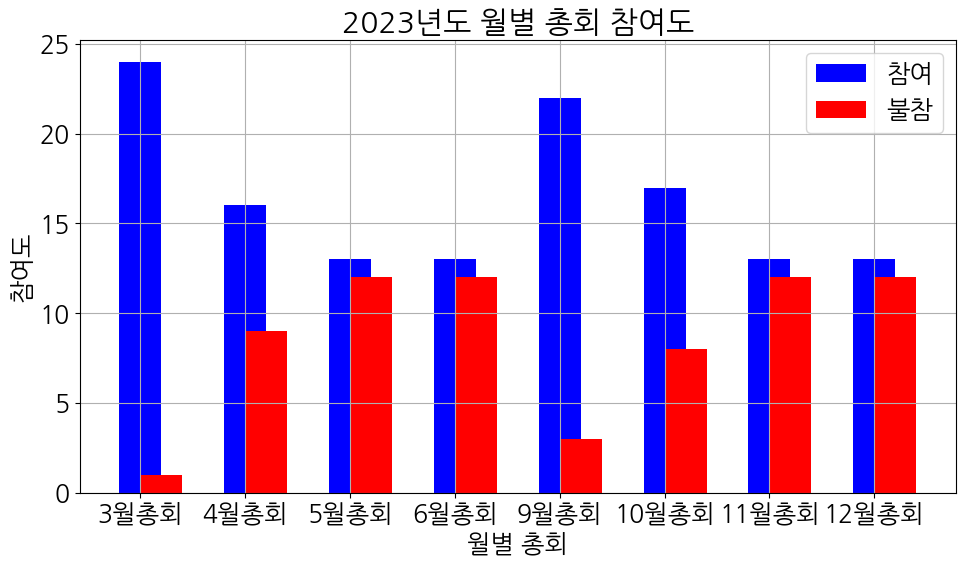

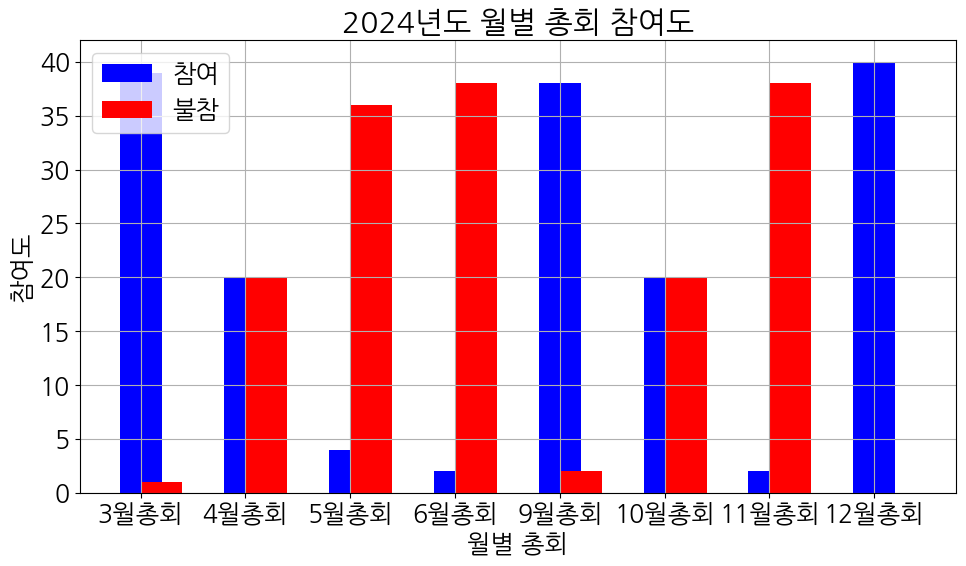

--------------------------------------------------------------------------------
연간 통계 서브 메뉴
1. 월별 총회 참여도
2. 봉사활동별 참여도
3. 봉사 시간 히스토그램과 정규분포
0. 뒤로 가기
--------------------------------------------------------------------------------
>>메뉴를 선택하세요: 2


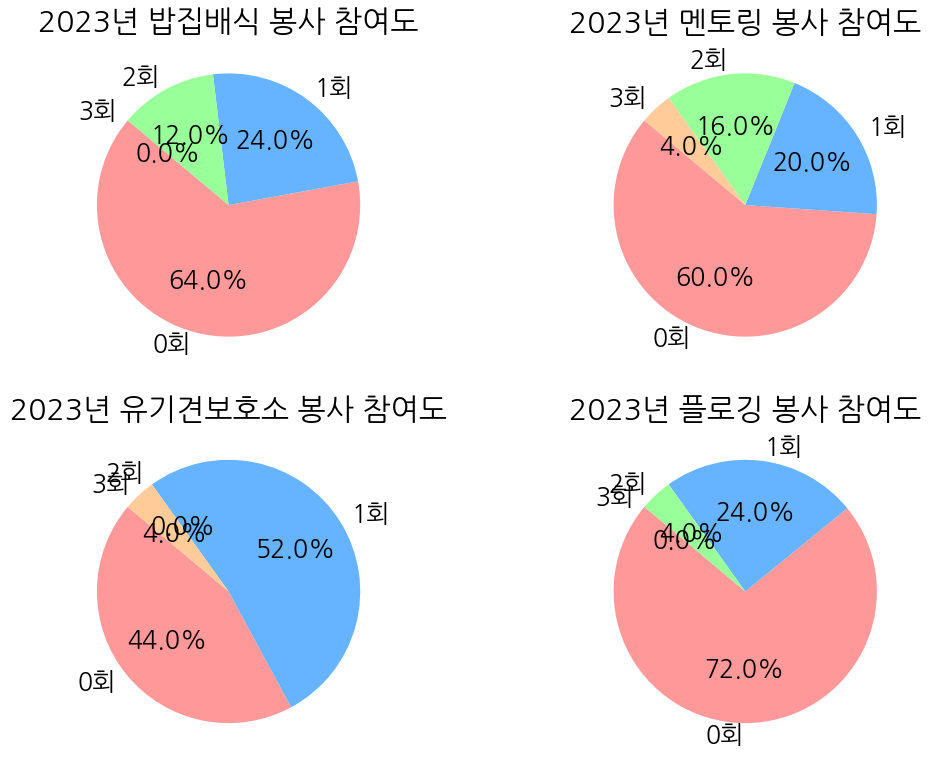

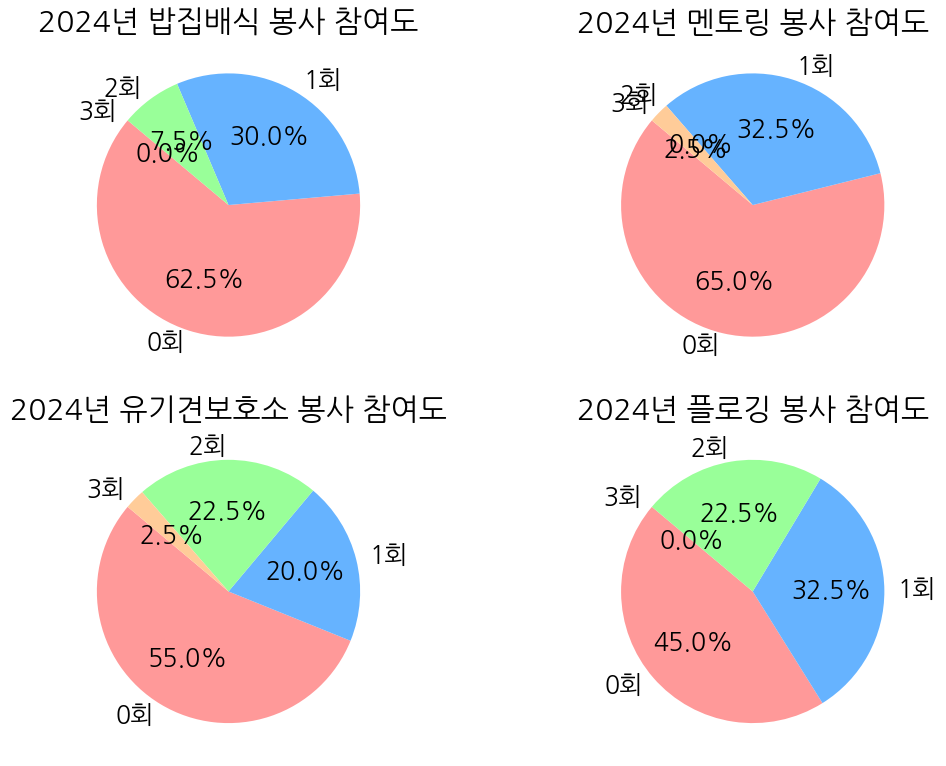

--------------------------------------------------------------------------------
연간 통계 서브 메뉴
1. 월별 총회 참여도
2. 봉사활동별 참여도
3. 봉사 시간 히스토그램과 정규분포
0. 뒤로 가기
--------------------------------------------------------------------------------
>>메뉴를 선택하세요: 3


<Figure size 1000x600 with 0 Axes>

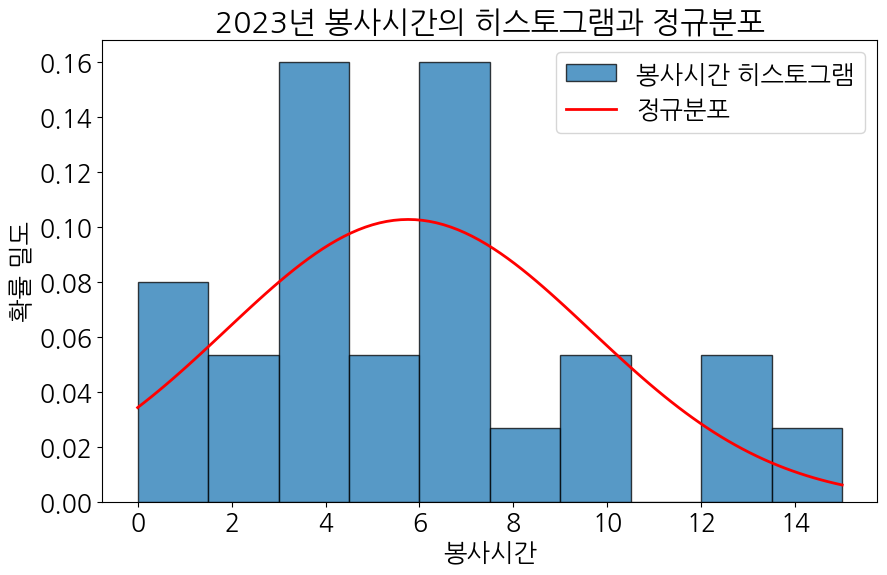

<Figure size 1000x600 with 0 Axes>

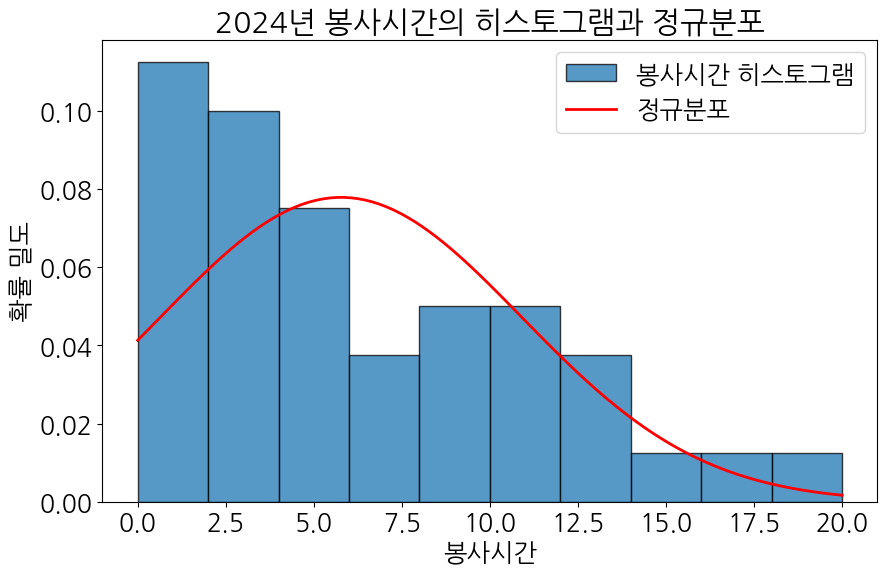

--------------------------------------------------------------------------------
연간 통계 서브 메뉴
1. 월별 총회 참여도
2. 봉사활동별 참여도
3. 봉사 시간 히스토그램과 정규분포
0. 뒤로 가기
--------------------------------------------------------------------------------
>>메뉴를 선택하세요: 0
--------------------------------------------------------------------------------
운영진 메뉴
1. 계정 관리
2. 활동내역 확인
3. 활동 관리
4. 부원 관리
5. 동아리 활동 연간 통계
6. 인수인계
0. 프로그램 종료
--------------------------------------------------------------------------------
메뉴를 선택하세요: 6
>>새로운 운영진의 학번을 입력하세요: 20240743
>>비밀번호 네자리를 입력하세요: 5306

---인증 성공---

NAME                          조우지
COURSE                      기계공학과
REGISTERSEMESTER       2023.03.01
ISOB                            0
ISMANAGER                   False
PHONENUM            010-0000-0000
Name: 20230618, dtype: object
NAME                          서재유
COURSE                     유럽문화학과
REGISTERSEMESTER       2024.03.01
ISOB                            0
ISMANAGER                    True
PHONENUM            010-432

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# 사용자로부터 입력 받기
input_id = int(input(">>학번을 입력하세요: "))

input_password = int(input(">>비밀번호 네자리를 입력하세요: "))
start_time = time.time()
# 인증 실행
if authenticate_user(input_id, input_password):
    print("\n---인증 성공---\n")
    log_data(filename, f"{input_id} 접속시작")
    df = pd.read_excel('MEMBER.xlsx', sheet_name='Sheet1')
    user_row = df[(df['ID'] == input_id)]
    print(">>정보를 불러옵니다:\n")

    #접속 시간
    access_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f">>데이터베이스 접속 시간: {access_time}\n")
    log_data(filename, f"{access_time} 접속 시간")

    #운영진 권한 확인
    if user_row['ISMANAGER'].values[0] == True:
        print("\n---운영진 권한 인증 성공---\n")
        handle_admin_menu()
    else:
        print("\n---운영진 권한 인증 실패---\n")
        handle_user_menu()
else:
    print("\n---인증 실패---\n")

end_time = time.time()
execution_time = end_time - start_time
print(f"시스템 실행시간: {execution_time} seconds")
print("---시스템을 종료합니다---")

disconnect_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
log_data(filename, f"{input_id} 접속종료")
log_data(filename, f"{disconnect_time} 접속종료 시간")
# 로그 파일 다운로드
from google.colab import files
files.download(filename)

# input_id = 20230618 input_password = 3892
# 20240743 5306
# 20240798
# 20241462